In [1]:
from project_lib import *
from tqdm import tqdm

In [2]:
df = pd.read_csv('dataset_tmc.csv', parse_dates = ['Dates'], date_format = '%d/%m/%y')
df.columns = [i.lower() for i in df.columns]
df.columns = [i.replace(' ','_') for i in df.columns]
df = df.set_index('dates')

# Check NaNs
if df.isna().sum().sum() != 0:
    print('check NaNs in data')

# Drop Sat&Sun if any
df = df[df.index.dayofweek<5]

# as convention 1 week is 5 trading days and 1 month is 21 trading days so that each year has 252 trading days

In [3]:
# STRATEGY PARAMETERS
TRADED_SECURITIES = [
            'us_staples', 'eu_healthcare', 'japan', 'brazil', 'nasdaq', 'us_2y',
            'us_15y', 'germany_10y', 'uk_15y', 'us_hy', 'oil', 'ind_metals', 'agri',
            'gold', 'silver', 'eurusd', 'usdjpy', 'chfjpy', 'eurbrl', 'gbpmxn'
    ]

LONG_PARAMS = {10:0.05, 21:0.15, 63:0.25} # dict with lenght of window as key and percentile for longs as values
SHORT_PARAMS = {10:0.95, 21:0.85, 63:0.75} # dict with lenght of window as key and percentile for shorts as values
MA_FAST_WDW = 20
MA_SLOW_WDW = 60

SUPPORTIVE_PCTL_MOVE = 0.3
COUNTER_PCTL_MOVE = 0.2
TRADES_MAX_DAYS = 21

MAX_DOLLAR_LOSS = 100


In [4]:
# list to store all trades
trades_list = []
trades_pnl = {}

for security_id in tqdm(TRADED_SECURITIES):
    # generate signal based on standard strategy
    signal_all = meanrev_signal(df[security_id],
                                long_params = LONG_PARAMS,
                                short_params = SHORT_PARAMS,
                                ma_fast_wdw = MA_FAST_WDW,
                                ma_slow_wdw = MA_SLOW_WDW
                )

    # "start your backtest at t-10". hard coding initial date
    signal_all = signal_all.loc['2014-02-12':]

    # extract from all signal only the actual open buy/sell triggers
    signal_do = signal_all[signal_all!= 0]

    # iterates over all buy/sell signal and execute orders
    for dt_open, direction in zip(signal_do.index, signal_do):
        
        # create a unique id for each trade
        trade_id = security_id+'#'+str(dt_open)[:10]

        # price at which the trade is open
        price_open = df.loc[dt_open, security_id]

        # compute TP/SL returns and prices
        tp_return, sl_return = tp_sl_rule(df[security_id],
                                            dt_open,
                                            direction,
                                            supportive_pctl_move = SUPPORTIVE_PCTL_MOVE,
                                            counter_pctl_move = COUNTER_PCTL_MOVE
                                          )
        if direction == 1:
            price_tp = price_open * (1 + tp_return)
            price_sl = price_open * (1 + sl_return)
        elif direction == -1:
            price_tp = price_open * (1 - tp_return)
            price_sl = price_open * (1 - sl_return)

        # compute the optimal sizing such that all trades loses the same amount of $ if SL is hitted
        quantity = MAX_DOLLAR_LOSS/((price_open - price_sl)*direction)

        # store all trade info in df
        trade = pd.DataFrame({'security_id':security_id,
                                'dt_open':str(dt_open)[:10],
                                'price_open':price_open,
                                'direction':direction,
                                'quantity':quantity,
                                'price_tp':price_tp,
                                'price_sl':price_sl}, index=[trade_id])

        # create a temporary df that contains prices of instrument during trade
        dt_open_idxdf = list(df.index).index(dt_open)
        temp_px = df[[security_id]].iloc[dt_open_idxdf + 1: dt_open_idxdf + TRADES_MAX_DAYS + 1]
        temp_px['price_open'] = price_open
        temp_px['direction'] = direction
        temp_px['quantity'] = quantity
        temp_px['price_tp'] = price_tp
        temp_px['price_sl'] = price_sl

        # Check if and when a TP/SL is triggered and cut the temporary df accordingly
        if direction==1:
            temp_px['tp_hitted'] = (temp_px[security_id] > temp_px['price_tp']) * 1
            temp_px['sl_hitted'] = (temp_px[security_id] < temp_px['price_sl']) * 1
        elif direction==-1:
            temp_px['tp_hitted'] = (temp_px[security_id] < temp_px['price_tp']) * 1
            temp_px['sl_hitted'] = (temp_px[security_id] > temp_px['price_sl']) * 1

        temp_px['tp_sl_hitted'] = temp_px['tp_hitted'] + temp_px['sl_hitted']

        if 1 in list(temp_px['tp_sl_hitted']):
            dt_close = str(temp_px[temp_px['tp_sl_hitted']==1].index[:1][0])[:10]
            exit_type = 'TP/SL exit'
        else:
            dt_close = str(list(temp_px.index)[-1:][0])[:10]
            exit_type = 'max duration'

        temp_px = temp_px.loc[:dt_close]
        price_close = temp_px.loc[dt_close, security_id]

        # add closing trade date and price to trade df
        trade['dt_close'] = dt_close
        trade['price_close'] = price_close
        trade['duration'] = len(temp_px)
        trade['exit_condition'] = exit_type

        # collect trade and pnl
        trades_list.append(trade)
        trades_pnl[trade_id] = temp_px

trades_list = pd.concat(trades_list)
# compute trades' returns
trades_list['return'] = trade_return(trades_list)
# split between TP and SL exit explicitly
trades_list['exit_condition'] = trades_list['exit_condition'].mask((trades_list['exit_condition']=='TP/SL exit')&(trades_list['return']>0), 'TP exit')
trades_list['exit_condition'] = trades_list['exit_condition'].mask((trades_list['exit_condition']=='TP/SL exit')&(trades_list['return']<0), 'SL exit')

100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


In [5]:
trades_list.groupby('security_id').apply(lambda x: hit_ratio(x), include_groups=False).rename('hit_ratio').to_frame().join(
    trades_list.groupby('security_id').apply(lambda x: win_loss(x), include_groups=False).rename('win_loss').to_frame())

,hit_ratio,win_loss
security_id,,
agri,0.439236,1.259670
brazil,0.419014,1.470556
chfjpy,0.454206,1.491419
eu_healthcare,0.431065,1.247838
eurbrl,0.521495,1.304648
eurusd,0.464552,1.231536
gbpmxn,0.483636,1.374349
germany_10y,0.403419,1.301521
gold,0.406082,1.371829


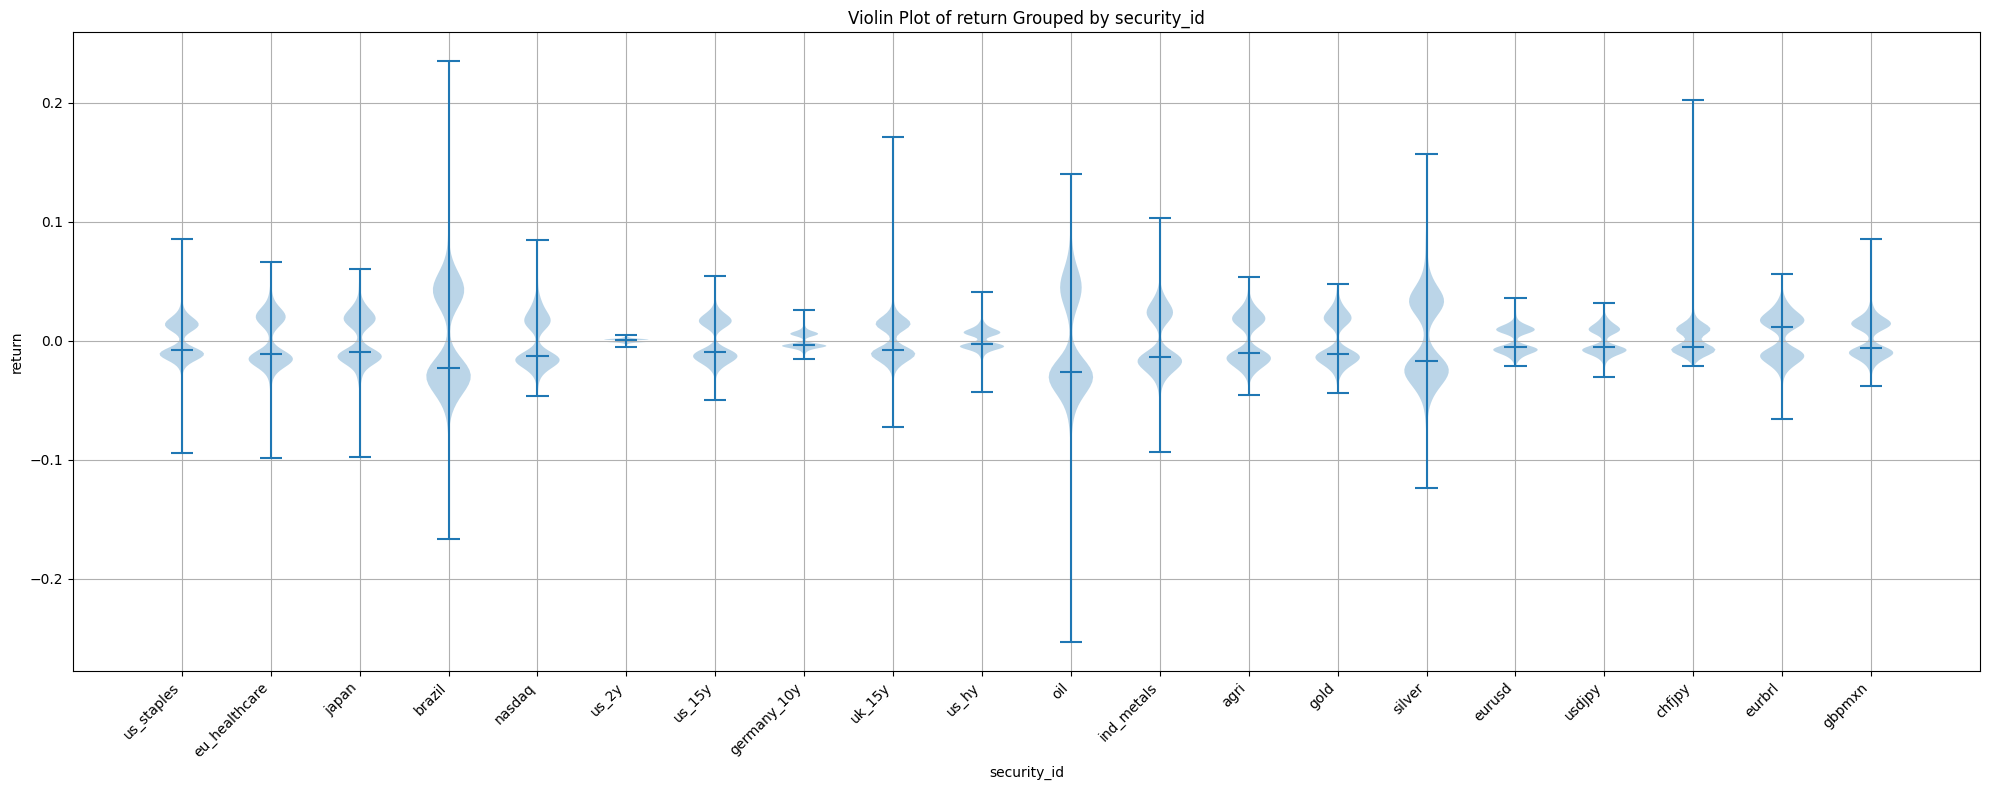

In [11]:
violin_plot_grouped(trades_list, 'security_id', 'return')

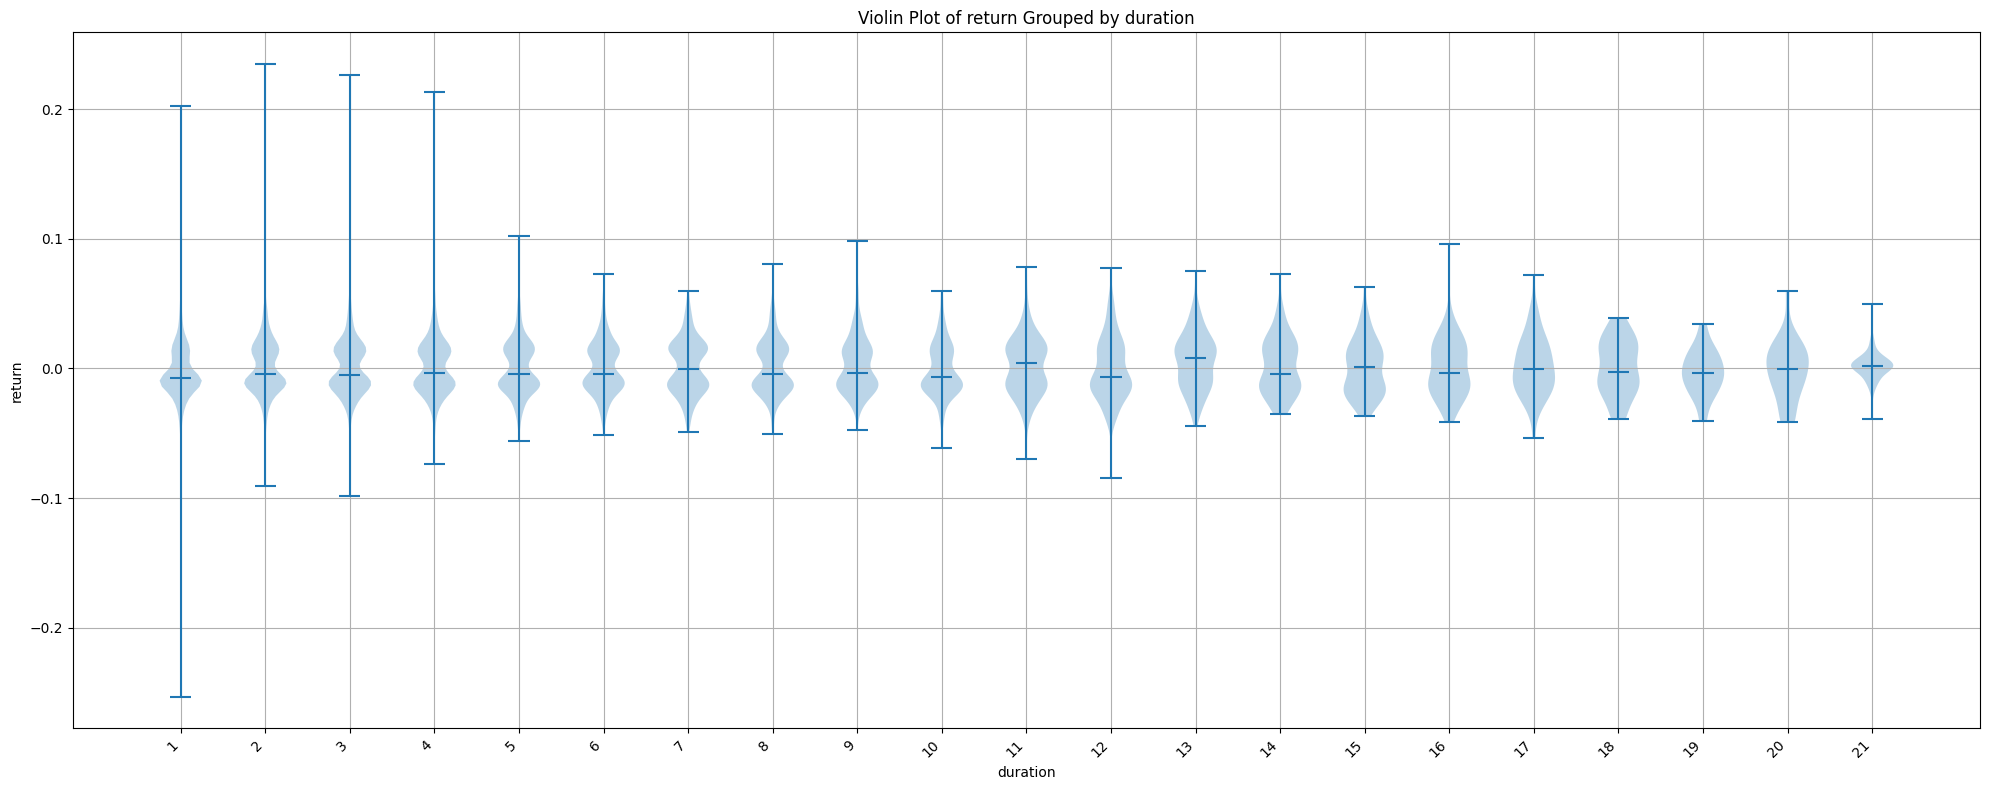

In [12]:
violin_plot_grouped(trades_list.sort_values(by='duration'), 'duration', 'return')

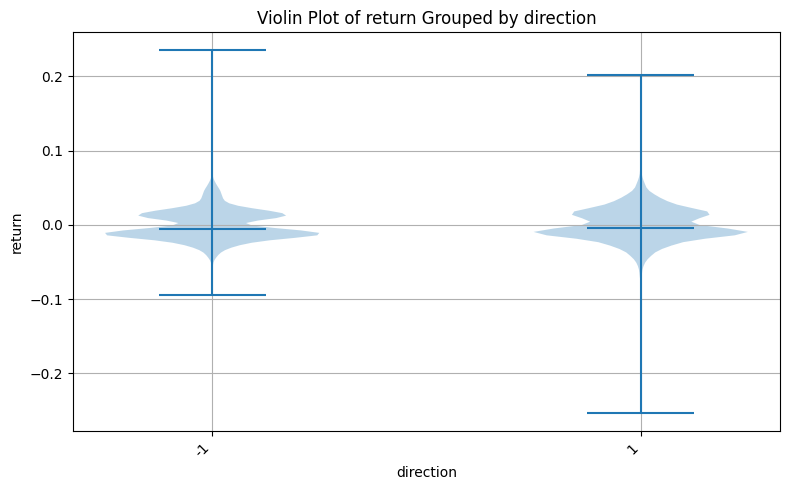

In [8]:
violin_plot_grouped(trades_list, 'direction', 'return', figsize=(8,5))

In [9]:
trades_list.groupby('security_id')['return'].describe()

,count,mean,std,min,25%,50%,75%,max
security_id,,,,,,,,
agri,576.0,-0.000122,0.019362,-0.045947,-0.015767,-0.010276,0.018192,0.053170
brazil,568.0,0.001148,0.044455,-0.166442,-0.031437,-0.022746,0.040609,0.234809
chfjpy,535.0,0.001066,0.015643,-0.020945,-0.007654,-0.005221,0.009300,0.202106
eu_healthcare,573.0,-0.000542,0.021387,-0.098154,-0.016046,-0.011579,0.019435,0.065872
eurbrl,535.0,0.003029,0.018758,-0.065801,-0.012839,0.011278,0.018032,0.056263
eurusd,536.0,0.000316,0.010326,-0.021123,-0.008019,-0.005290,0.009240,0.035495
gbpmxn,550.0,0.001711,0.014828,-0.037839,-0.010591,-0.005858,0.014429,0.085697
germany_10y,585.0,-0.000348,0.005882,-0.015643,-0.004627,-0.003519,0.005502,0.026094
gold,559.0,-0.000571,0.019055,-0.043921,-0.015114,-0.010965,0.018353,0.047789


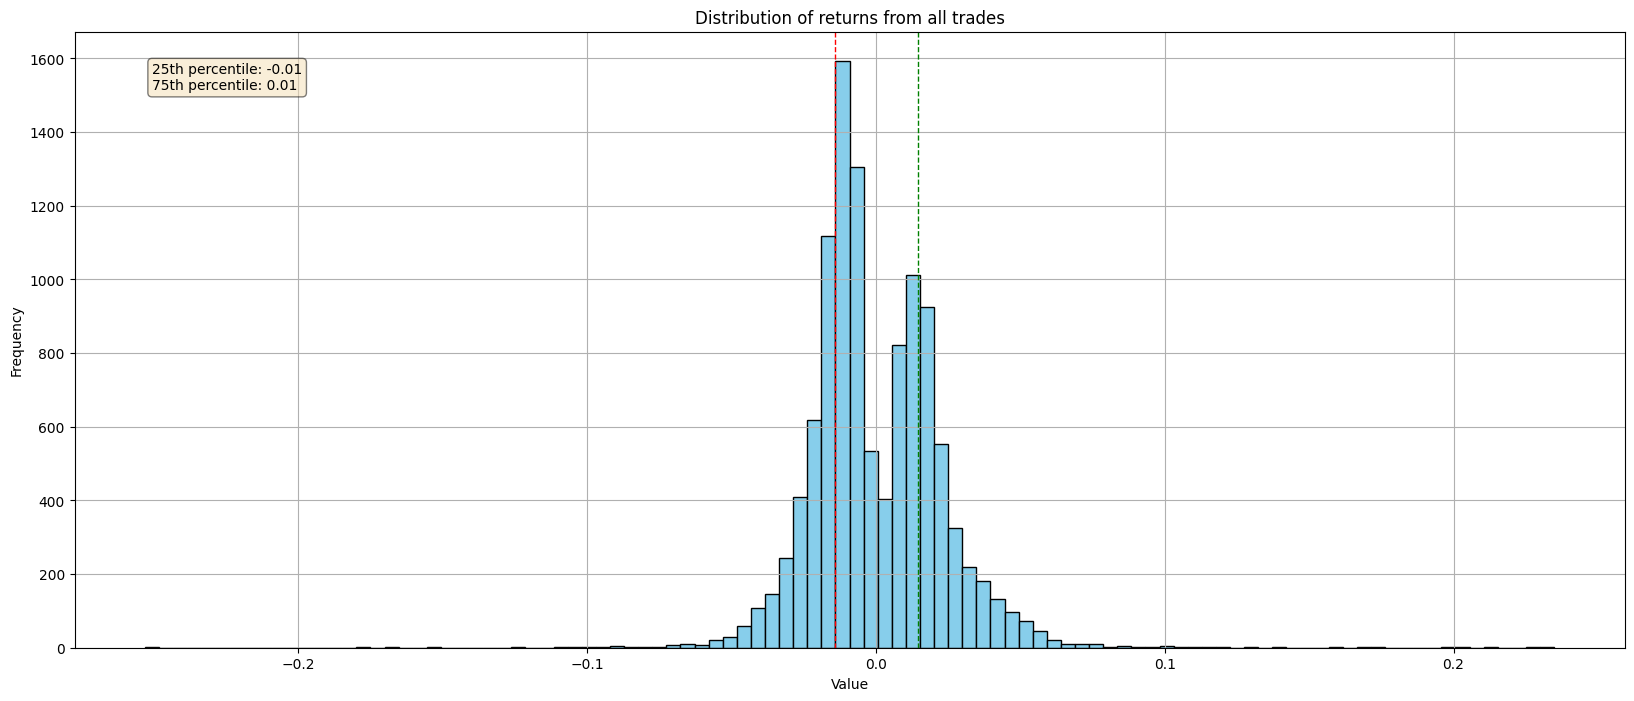

In [10]:
plot_histogram(trades_list['return'], 'Distribution of returns from all trades', figsize=(20, 8), bins=100)

In [16]:
trades_list['pnl'] = trades_list['price_open'] * trades_list['quantity'] * (trades_list['return'])

In [20]:
# controlla se ha senso

trades_list.groupby('security_id')['pnl'].sum()

security_id
agri             -1417.690922
brazil            2949.647187
chfjpy           13619.631611
eu_healthcare    -1941.941079
eurbrl           16527.415278
eurusd            2298.645861
gbpmxn           11367.698500
germany_10y      -6960.018613
gold             -4048.900237
ind_metals      -11405.462769
japan             5136.950696
nasdaq            4972.495187
oil             -16227.515860
silver             729.888811
uk_15y           -3487.861429
us_15y           -6241.543663
us_2y            13889.271110
us_hy            11101.306687
us_staples        4039.534373
usdjpy           -1127.164752
Name: pnl, dtype: float64